In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json 
import math
import scipy as sc
from itertools import islice
from random import sample
seed = 0

In [4]:
def get_network_mcf_json(fp: str, link_capacity: int) -> nx.Graph:

    with open(fp, mode='r') as file:
        in_data = json.load(file)

    G = nx.node_link_graph(in_data)
    nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), with_labels=True)
    nx.set_edge_attributes(G, link_capacity, "available_capacity")
    
    return G

In [5]:
from typing import List, Tuple 

def generate_demands(G: nx.Graph, total_flow: int) -> List[Tuple[int, int, int]]:
    #Initialize an empty list demands
    demands = []
    nodes = G.nodes()
    for i in range(total_flow):          #For each iteration in the range of total_flow:
        src, dst = np.random.choice(G.number_of_nodes(), size=(2,), replace=False)  #Randomly select two distinct nodes, src and dst, from the nodes in graph G
        rate = np.random.randint(100, 1000)
        demands.append((src, dst, rate))     #Append the tuple (src, dst) to the demands list

    return demands   #Return the demands list

In [6]:
def get_ksp(G: nx.Graph, n_paths: int, metric: str) -> dict[tuple[int, int]: list[int]]:
    
    ksp = {}                #Initialize an empty dictionary ksp
    for i in G.nodes:       #For each node i in the graph G:
        for j in G.nodes:   #For each node j in the graph G:
            if i < j:       #If i is less than j:
                            #Find the first n_paths shortest paths between nodes i and j in G using the specified metric
                paths = list(islice(nx.shortest_simple_paths(G, i, j, metric), n_paths))
                ksp[i, j] = paths
                ksp[j, i] = paths
                
    return ksp  #Return the dictionary ksp

In [7]:
def get_network_rwa_json(fp: str, n_wavelengths: int) -> nx.Graph:
    
    with open(fp, mode='r') as file:    #Open the file at path fp in read mode as file
        in_data = json.load(file)       #Load JSON data from file into data
   
    G = nx.node_link_graph(in_data)     #Convert data into a graph G using node-link format
    available_wavelengths = {}          #Initialize an empty dictionary available_wavelengths

    for edge in G.edges():              #For each edge in G:
        available_wavelengths[edge] = np.ones((n_wavelengths,), dtype=np.uint8)        #Set available_wavelengths[edge] to an array of ones with length n_wavelengths and data type uint8

    nx.set_edge_attributes(G, available_wavelengths, "available_wavelengths")           #Set the "available_wavelengths" attribute for all edges in G to the available_wavelengths dictionary
    G.graph["n_wavelengths"] = n_wavelengths                                        #Set the graph attribute "n_wavelengths" in G to n_wavelengths

    return G                            #Return the graph G 

In [19]:
def sap_ff_rwa_variable(G: nx.Graph, demands: list, ksp: dict, dataPerWave: int, modReach: int) -> tuple[int, list]:
    n_routed_demands = 0    # Initialize the number of successfully routed demands and the list to store routed demands
    routed_demands = []
    num_utilized_wavelengths = 0 # Initialize the number of utilized wavelengths and the number of amplifiers needed
    num_amplifiers_needed = 0
    for src, dst, rate in demands:    # Iterate over each demand (source, destination, required rate)
                                                                    # Calculate the number of wavelengths required to satisfy the demand
        num_waves_needed = (rate + dataPerWave - 1) // dataPerWave  # Ceiling division to ensure enough wavelengths
        
        for path in ksp[(src, dst)]:        # Iterate over all paths for the source-destination pair in the ksp dictionary
            available_waves = []

            for wav in range(G.graph["n_wavelengths"]):        # Iterate over each wavelength to find a set of consecutive free wavelengths
                is_wavelength_free = True

                for i in range(len(path) - 1):    # 'for' to ensure wavelength continuity
                    # Check if the current wavelength is free along the entire path
                    if G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 0:
                        is_wavelength_free = False
                        break

                if is_wavelength_free:
                    available_waves.append(wav)

                if len(available_waves) == num_waves_needed:   # If enough wavelengths are found, break out of the loop
                    break

            # Check if enough wavelengths were found to route the demand
            if len(available_waves) == num_waves_needed:
                for wav in available_waves:
                    for i in range(len(path) - 1):
                        # Assert that the wavelength is indeed free and then mark it as used
                        assert G[path[i]][path[i + 1]]["available_wavelengths"][wav] == 1
                        G[path[i]][path[i + 1]]["available_wavelengths"][wav] = 0
                        num_utilized_wavelengths += 1
                        if "length" in G[path[i]][path[i + 1]]:
                            num_amplifiers_needed += G[path[i]][path[i + 1]]["length"] // modReach  # considering the node as a amplifier

                # Record the routed demand information
                n_routed_demands += 1
                routed_demands.append((src, dst, path, available_waves))
                break
    print("Number of utilized wavelengths:", num_utilized_wavelengths)
    print("Number of amplifiers needed:", num_amplifiers_needed)
    return n_routed_demands, routed_demands


In [11]:

def runHeuristic(G: nx.Graph, demands: list, num_spectrum: int, plot_usage: bool, n_wavelengths: int, ratePerWave: int, modReach: int) -> tuple[int, bool]:
    ksp = get_ksp(G, 5, 'length')
    print(f'We generated {len(demands)} demands')
    n_routed_demands, routed_demands = sap_ff_rwa_variable(G,demands, ksp, ratePerWave, modReach)
    print(f'We routed {n_routed_demands} demands')
    # Dictionary to store the indexes of demands routed on each edge
    edge_demand_map = {edge: [] for edge in G.edges}
    if plot_usage:
        plt_1 = plt.figure(figsize=(16, 9))
        nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)
        alpha_step = round(1/n_wavelengths, 2)

    for demand_index, demand in enumerate(routed_demands):
        route = demand[-2]
        route_el = list(zip(route, route[1:]))
        num_spectrum += len(route_el)
        
        # Update the edge_demand_map with the current demand index
        for edge in route_el:
            if edge in edge_demand_map:
                edge_demand_map[edge].append(demand_index)
            elif (edge[1], edge[0]) in edge_demand_map:
                edge_demand_map[(edge[1], edge[0])].append(demand_index)
            else:
                edge_demand_map[edge] = [demand_index]
                
        if plot_usage:
            nx.draw_networkx_edges(G, pos=nx.get_node_attributes(G, "pos"), edgelist=route_el, width=10, alpha=alpha_step, edge_color='red')
            #label every edge with all indexes of demands it is carrying

    if plot_usage:
        # Label every edge with the indexes of demands it is carrying
        edge_labels = {edge: ','.join(map(str, indexes)) for edge, indexes in edge_demand_map.items() if indexes}
        nx.draw_networkx_edge_labels(G, pos=nx.get_node_attributes(G, 'pos'), edge_labels=edge_labels, font_size=11, font_weight='bold')

        # nx.draw_networkx_edge_labels(
        #     G, pos=nx.get_node_attributes(G, 'pos'),
        #     edge_labels=nx.get_edge_attributes(G, 'available_wavelengths'),
        #     bbox=dict(alpha=0),
        #     font_size=11,
        #     font_weight='bold',
        #     verticalalignment='center')
    print(f"Spectrum occupation is: {num_spectrum}")
    if n_routed_demands == len(demands):
        print("All demands were routed")
        return num_spectrum, True
    else:
        print(f"Only {n_routed_demands} demands were routed")
        return num_spectrum, False

In [ ]:
# Define the data as a list of dictionaries
data_table = [
    {"Data Rate (Gb/s)": 800, "Bits/symbol (Gb/s)": 5.67, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 150},
    {"Data Rate (Gb/s)": 700, "Bits/symbol (Gb/s)": 5.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 400},
    {"Data Rate (Gb/s)": 600, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 700},
    {"Data Rate (Gb/s)": 500, "Bits/symbol (Gb/s)": 3.60, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 1300},
    {"Data Rate (Gb/s)": 400, "Bits/symbol (Gb/s)": 3.00, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 2500},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 2.39, "Channel spacing (Δf) (GHz)": 100, "Reach (km)": 4700},
    {"Data Rate (Gb/s)": 300, "Bits/symbol (Gb/s)": 6.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 100},
    {"Data Rate (Gb/s)": 200, "Bits/symbol (Gb/s)": 4.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 900},
    {"Data Rate (Gb/s)": 100, "Bits/symbol (Gb/s)": 2.00, "Channel spacing (Δf) (GHz)": 50, "Reach (km)": 3000},
]

def set_parameters(mod):
    """
    Set variables based on the selected mode (mod).
    Args:
    mod (int): The index of the desired mode (0 to 8).
    
    Returns:
    tuple: datarate, entropy, spacing, and reach for the selected mode.
    """
    if 0 <= mod < len(data_table):
        entry = data_table[mod]
        datarate = entry["Data Rate (Gb/s)"]
        entropy = entry["Bits/symbol (Gb/s)"]
        spacing = entry["Channel spacing (Δf) (GHz)"]
        reach = entry["Reach (km)"]
        return datarate, entropy, spacing, reach
    else:
        raise ValueError("Invalid mode selected. Please choose a value between 0 and 8.")

# Example: User chooses a mode (e.g., mod = 1)
# mod = 7# Change this value to set a different mode

# Get the parameters for the selected mode and assign to variables
# datarate, entropy, spacing, reach = set_parameters(mod)

# Display the parameters
# print(f"Datarate: {datarate} Gb/s")
# print(f"Entropy: {entropy} Bits/symbol")
# print(f"Channel Spacing: {spacing} GHz")
# print(f"Reach: {reach} km")


Datarate: 200 Gb/s
Entropy: 4.0 Bits/symbol
Channel Spacing: 50 GHz
Reach: 900 km


Datarate: 200 Gb/s
Channel Spacing: 50 GHz
Reach: 900 km

TM: [(2, 0, 647), (1, 5, 683)]
We generated 2 demands
Number of utilized wavelengths: 12
Number of amplifiers needed: 0
We routed 2 demands
Spectrum occupation is: 3
All demands were routed

Link: (0, 1)
Length: None
Wavelength utilization: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (0, 2)
Length: None
Wavelength utilization: [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (1, 2)
Length: None
Wavelength utilization: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Link: (1, 

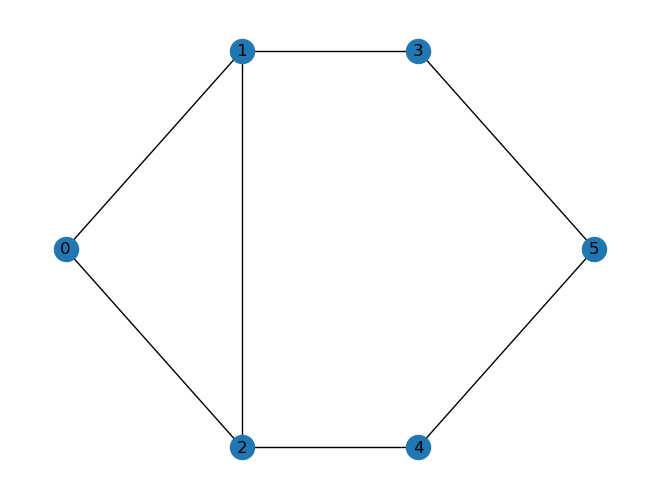

In [23]:
from ortools.linear_solver import pywraplp
channelPerBand = 96 #at 50GHz

mod = 7 # Change this value to set a different mode
plot_usage = False
# Get the parameters for the selected mode and assign to variables
datarate, entropy, spacing, reach = set_parameters(mod)

G = get_network_rwa_json("./graph.json", n_wavelengths=int(channelPerBand * 50 / spacing)) #number of wavelength set according to modulation chosen
nx.draw(G, pos=nx.get_node_attributes(G, "pos"), with_labels=True)

# Display the parameters
print(f"Datarate: {datarate} Gb/s")
print(f"Channel Spacing: {spacing} GHz")
print(f"Reach: {reach} km")

TM = generate_demands(G, 2)
for edge in G.edges:
    G.edges[edge]["capacity"] = (channelPerBand * 50 / spacing) * datarate 
    G.edges[edge]["n_wavelength"] = channelPerBand * 50 / spacing

print(f"\nTM: {TM}")
spectrum, all_routed = runHeuristic(G, TM, 
                                    num_spectrum=0, 
                                    plot_usage=False, 
                                    n_wavelengths=int(channelPerBand * 50 / spacing),
                                    ratePerWave=datarate,
                                    modReach=reach)

for edge in G.edges:
    print(f'\nLink: {edge}\nLength: {G.edges[edge].get("length")}\nWavelength utilization: {G.edges[edge]["available_wavelengths"]}')